## NYC Taxi Fare Prediction Model ##

In [1]:
# Dependencies
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import calendar
import time
from math import sin, cos, sqrt, atan2, radians,asin
import matplotlib.dates as mdates
import matplotlib as mpl
from datetime import timedelta
import datetime as dt
from taxi_functions import distance, boundaryBox, isLocation

% matplotlib inline
plt.style.use('seaborn-whitegrid')

#### Load datasets ####

In [42]:
# import training data
start_time = time.time() # track time
train_df = pd.read_csv('all/train_cleaned.csv')
print("%s seconds" % (time.time() - start_time))

TypeError: parser_f() got an unexpected keyword argument 'index'

In [246]:
# insert testing data
start_time = time.time() # track time
test_df = pd.read_csv('all/test_cleaned.csv')
print("%s seconds" % (time.time() - start_time))

0.17171502113342285 seconds


## Baseline Model ##

In [3]:
print("Training set has {} samples.".format(train_df.shape[0]))
print("Testing set has {} samples.".format(test_df.shape[0]))

Training set has 14627950 samples.
Testing set has 9914 samples.


In [4]:
# Split the train data for model training
from sklearn.model_selection import train_test_split 
X_train, X_test, y_train, y_test = train_test_split(train_df.drop('fare_amount', axis=1),
                                                    train_df['fare_amount'], test_size=0.15, random_state = 111)

# Check shape
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(12433757, 33)
(2194193, 33)
(12433757,)
(2194193,)


In [5]:
from sklearn.metrics import mean_squared_error, explained_variance_score

def plot_prediction_analysis(y, y_pred, figsize=(10,4), title=''):
    fig, axs = plt.subplots(1, 2, figsize=figsize)
    axs[0].scatter(y, y_pred)
    mn = min(np.min(y), np.min(y_pred))
    mx = max(np.max(y), np.max(y_pred))
    axs[0].plot([mn, mx], [mn, mx], c='red')
    axs[0].set_xlabel('$y$')
    axs[0].set_ylabel('$\hat{y}$')
    rmse = np.sqrt(mean_squared_error(y, y_pred))
    evs = explained_variance_score(y, y_pred)
    axs[0].set_title('rmse = {:.2f}, evs = {:.2f}'.format(rmse, evs))
    
    axs[1].hist(y-y_pred, bins=50)
    avg = np.mean(y-y_pred)
    std = np.std(y-y_pred)
    axs[1].set_xlabel('$y - \hat{y}$')
    axs[1].set_title('Histrogram prediction error, $\mu$ = {:.2f}, $\sigma$ = {:.2f}'.format(avg, std))
    
    if title!='':
        fig.suptitle(title)

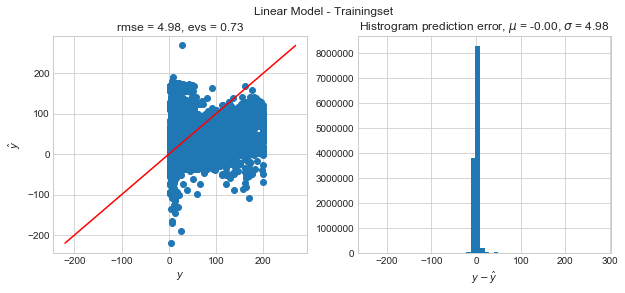

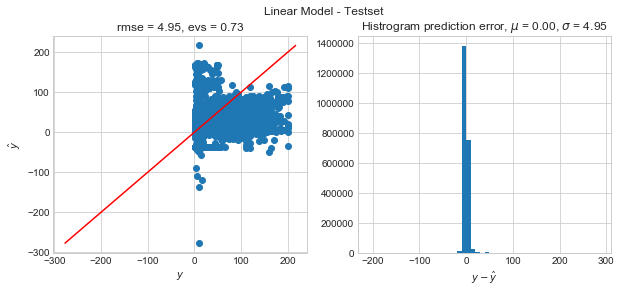

In [75]:
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression

model_lin = LinearRegression()
model_lin.fit(X_train, y_train)
model = LinearRegression()
model.fit(X_train, y_train)

y_train_pred = model.predict(X_train)
plot_prediction_analysis(y_train, y_train_pred, title='Linear Model - Trainingset')

y_test_pred = model.predict(X_test)
plot_prediction_analysis(y_test, y_test_pred, title='Linear Model - Testset')

RMSE for the naive (base) model is 4.98 on the training set and 4.95 on the test set. 

## Model Selection ##

In [44]:
X = X_train.head(200000)
y = y_train.head(200000)

In [46]:
X = X.drop(['Unnamed: 0'], axis = 1)

In [48]:
import eli5
from eli5.sklearn import PermutationImportance
import lightgbm as lgbm
from sklearn.ensemble import RandomForestRegressor;

In [49]:
train_X, test_X, train_y, test_y = train_test_split(X, y, random_state = 1)

Going to try a few regression models:
(recommendations taken from scikit-learn algorithm cheat sheet, regression problems with <100k 
samples.

    * Lasso
    * ElasticNet
    * RidgeRegression
    * GradientBoostingRegressor
    * AdaBoostRegressor
    * LightGradientBoostingRegressor

In [65]:
def train_predict(learner, sample_size, X_train, y_train, X_test, y_test):
    
    results = {}
    
    start = time.time()
    learner.fit(X_train[:sample_size], y_train[:sample_size])
    end = time.time()
    
    results['train_time'] = end - start
    
    start = time.time()
    predictions_train = learner.predict(X_train)
    predictions_test = learner.predict(X_test)
    end = time.time()
    
    results['pred_time'] = start - end
    
    
    results['rmse_train'] = np.sqrt(mean_squared_error(y_train, predictions_train))
    results['rmse_test'] = np.sqrt(mean_squared_error(y_test, predictions_test))
    
    print("{} trained on {} samples.".format(learner.__class__.__name__, sample_size))
    
    return results

In [66]:
from sklearn.linear_model import Lasso, ElasticNet, Ridge
from sklearn.ensemble import GradientBoostingRegressor, AdaBoostRegressor
# first_model = RandomForestRegressor(n_estimators=30, random_state=1).fit(train_X, train_y)

reg_A = Lasso(random_state = 42)
reg_B = ElasticNet(random_state = 42)
reg_C = Ridge(random_state = 42)
reg_D = GradientBoostingRegressor(random_state = 42)
reg_E = AdaBoostRegressor(random_state = 42)

samples_100 = len(train_y)
samples_10 = int(len(train_y) * 0.1)
samples_1 = int(len(train_y) * 0.01)

In [67]:
# collect results from learners
results = {}
for reg in [reg_A, reg_B, reg_C, reg_D, reg_E]:
    reg_name = reg.__class__.__name__
    results[reg_name] = {}
    for i, samples in enumerate([samples_1, samples_10, samples_100]): \
        results[reg_name][i] = train_predict(reg, samples, train_X, train_y, test_X, test_y)

Lasso trained on 1500 samples.
Lasso trained on 15000 samples.
Lasso trained on 150000 samples.
ElasticNet trained on 1500 samples.
ElasticNet trained on 15000 samples.
ElasticNet trained on 150000 samples.
Ridge trained on 1500 samples.
Ridge trained on 15000 samples.
Ridge trained on 150000 samples.
GradientBoostingRegressor trained on 1500 samples.
GradientBoostingRegressor trained on 15000 samples.
GradientBoostingRegressor trained on 150000 samples.
AdaBoostRegressor trained on 1500 samples.
AdaBoostRegressor trained on 15000 samples.
AdaBoostRegressor trained on 150000 samples.


In [68]:
# Visual plot functions taken from earlier MLND Project: Finding Donors
import gc
from visuals import evaluate
import matplotlib.patches as mpatches

In [69]:
def evaluate(results):
    """
    Visualization code to display results of various learners.
    
    inputs:
      - learners: a list of supervised learners
      - stats: a list of dictionaries of the statistic results from 'train_predict()'
      - accuracy: The score for the naive predictor
      - f1: The score for the naive predictor
    """
  
    # Create figure
    fig, ax = plt.subplots(2, 2, figsize = (10,10))

    # Constants
    bar_width = 0.2
    colors = ['#A00000','#00A0A0','#00A000', '#A00AAA', '#AAAADC']
    
    # Super loop to plot four panels of data
    for k, learner in enumerate(results.keys()):
        for j, metric in enumerate(['train_time', 'rmse_train', 'pred_time', 'rmse_test']):
            for i in np.arange(3):
                
                # Creative plot code
                ax[j//2, j%2].bar(i+k*bar_width, results[learner][i][metric], width = bar_width, color = colors[k])
                ax[j//2, j%2].set_xticks([0.45, 1.45, 2.45])
                ax[j//2, j%2].set_xticklabels(["1%", "10%", "100%"])
                ax[j//2, j%2].set_xlabel("Training Set Size")
                ax[j//2, j%2].set_xlim((-0.1, 3.0))
    
    # Add unique y-labels
    ax[0, 0].set_ylabel("Time (in seconds)")
    ax[0, 1].set_ylabel("RMSE")
    ax[1, 0].set_ylabel("Time (in seconds)")
    ax[1, 1].set_ylabel("RMSE")
    
    # Add titles
    ax[0, 0].set_title("Model Training")
    ax[0, 1].set_title("RMSE on Training Subset")
    ax[1, 0].set_title("Model Predicting")
    ax[1, 1].set_title("RMSE on Testing Set")
    
    # Set y-limits for score panels
    ax[0, 0].set_ylim((0, 300))
    ax[0, 1].set_ylim((0, 10))
    ax[1, 0].set_ylim((0, 1))
    ax[1, 1].set_ylim((0, 10))
    
    # Benchmarks from naive model
    ax[0, 1].axhline(y = 4.98, xmin = -0.1, xmax = 3.0, linewidth = 1, color = 'k', linestyle = 'dashed')
    ax[1, 1].axhline(y = 4.97, xmin = -0.1, xmax = 3.0, linewidth = 1, color = 'k', linestyle = 'dashed')

    # Create patches for the legend
    patches = []
    for i, learner in enumerate(results.keys()):
        patches.append(mpatches.Patch(color = colors[i], label = learner))
    plt.legend(handles = patches, bbox_to_anchor = (3, 3), \
               loc = 'best', borderaxespad = 0., ncol = 3, fontsize = 'x-large')
    
    # Aesthetics
    plt.suptitle("Performance Metrics for Five Supervised Learning Models", fontsize = 16, y = 1.10)
    plt.show()
    

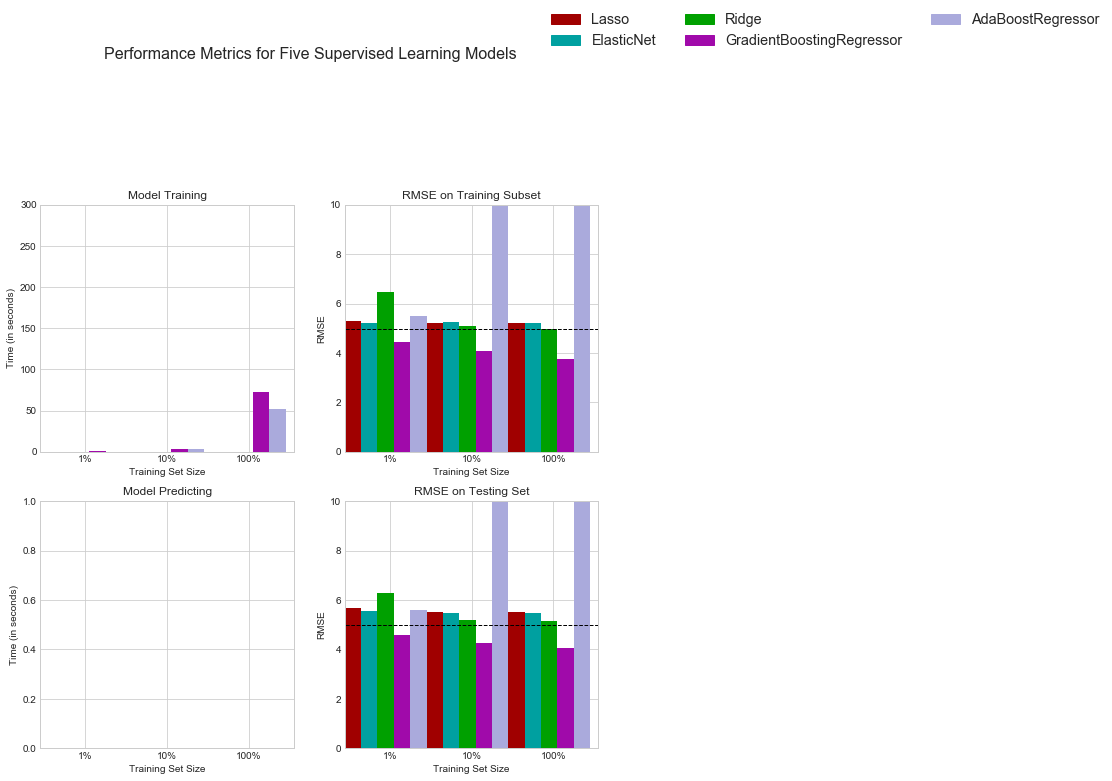

In [71]:
evaluate(results)

In [86]:
reg = GradientBoostingRegressor(random_state=42)
reg.fit(train_X, train_y)
predictions = reg.predict(test_X)


In [94]:
def rmse(y, y_pred):
    return np.sqrt(mean_squared_error(y, y_pred))

In [96]:
print(rmse(predictions, test_y))

4.053438173093389


### Use Permutation Importance to Double Check Feature importance ###

In [93]:
perm = PermutationImportance(reg, random_state = 1).fit(train_X, train_y)
eli5.show_weights(perm, feature_names = train_X.columns.tolist())

Weight,Feature
0.3477 ± 0.0013,log_distance
0.3240 ± 0.0011,distance
0.0810 ± 0.0006,dropoff_longitude
0.0421 ± 0.0017,pickup_year
0.0234 ± 0.0009,dropoff_latitude
0.0072 ± 0.0011,night_hour
0.0046 ± 0.0002,dropoff_distance_to_jfk
0.0035 ± 0.0002,pickup_distance_to_ewr
0.0034 ± 0.0002,dropoff_distance_to_Nassau
0.0028 ± 0.0001,pickup_distance_to_jfk


In [97]:
perm_features = ['log_distance', 'distance', 'dropoff_longitude', 'pickup_year', 'dropoff_latitude', 'night_hour']

In [98]:
perm_X = X[perm_features]
perm_y = y

In [103]:
perm_train_X, perm_test_X, perm_train_y, perm_test_y = train_test_split(perm_X, perm_y, random_state = 1)

In [112]:
perm_reg = GradientBoostingRegressor(random_state=42)
perm_reg.fit(perm_train_X, perm_train_y)
perm_pred = perm_reg.predict(perm_test_X)

In [113]:
print(rmse(perm_pred, perm_test_y))

4.0972488658079


We'll keep our features list as is for now, as our loss function got slightly worse. We could continue to tweak this to improve score (for future work). 

Even though training time is longer, we'll stick with the GradientBoostingRegressor since we care about minimizing loss more than optimizing for speed / running our model in real time given this problem space.

In [127]:
X = X_train.head(10000)
y = y_train.head(10000)
X = X.drop(['Unnamed: 0'], axis = 1)
train_X, test_X, train_y, test_y = train_test_split(X, y, random_state = 1)

In [128]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer

# Initialize regressor
reg = GradientBoostingRegressor(random_state=42)

# Parameter list to tune
parameters = {'n_estimators': [25, 50, 100],
              'max_depth': [4, 5, 6], 
              'learning_rate': [0.005, 0.1, 0.2],
              'min_samples_split': [2, 3]}

scorer = make_scorer(rmse, greater_is_better = False)

# Perform grid_search on the regressor
grid_obj = GridSearchCV(estimator = reg, param_grid = parameters, scoring = scorer)

# Fit the grid search object to the training data
grid_fit = grid_obj.fit(train_X, train_y)

# Get the estimator
best_reg = grid_fit.best_estimator_

# Make predictions
predictions = (reg.fit(train_X, train_y)).predict(test_X)
best_predictions = best_reg.predict(test_X)

# Report the before-and-afterscores
print("Unoptimized model\n------")
print("RMSE on testing data: {:.4f}".format(rmse(test_y, predictions)))
print("\nOptimized Model\n------")
print("RMSE on the testing data: {:.4f}".format(rmse(test_y, best_predictions)))

Unoptimized model
------
RMSE on testing data: 3.8706

Optimized Model
------
RMSE on the testing data: 3.8310


In [121]:
best_reg

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=5, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=3, min_weight_fraction_leaf=0.0,
             n_estimators=100, presort='auto', random_state=42,
             subsample=1.0, verbose=0, warm_start=False)

In [150]:
X_train = X_train.drop(['Unnamed: 0'], axis = 1)

ValueError: labels ['Unnamed: 0'] not contained in axis

In [153]:
X_test = X_test.drop(['Unnamed: 0'], axis = 1)

In [169]:
model = best_reg

In [269]:
X_train_cut = X_train.head(3000000)
y_train_cut = y_train.head(3000000)

In [175]:
model.fit(X_train_cut, y_train_cut)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=4, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=3, min_weight_fraction_leaf=0.0,
             n_estimators=100, presort='auto', random_state=42,
             subsample=1.0, verbose=0, warm_start=False)

In [176]:
gmb_pred = model.predict(X_test)

In [178]:
print("RMSE on the testing data: {:.4f}".format(rmse(y_test, gmb_pred)))

RMSE on the testing data: 3.8823


### Testing out LightGBM ###

In [143]:
import lightgbm as lgbm
params = {
        'boosting_type':'gbdt',
        'objective': 'regression',
        'nthread': 4,
        'num_leaves': 31,
        'learning_rate': 0.1,
        'max_depth': 5,
        'subsample': 0.8,
        'bagging_fraction' : 1,
        'max_bin' : 5000 ,
        'bagging_freq': 20,
        'colsample_bytree': 0.6,
        'metric': 'rmse',
        'min_split_gain': 0.5,
        'min_child_weight': 1,
        'min_child_samples': 10,
        'scale_pos_weight':1,
        'zero_as_missing': True,
        'seed':0,
        'num_rounds':50000
    }


def LGBMmodel(X_train,X_test,y_train,y_test,params):
    matrix_train = lgbm.Dataset(X_train, y_train)
    matrix_test = lgbm.Dataset(X_test, y_test)
    model=lgbm.train(params=params,
                    train_set=matrix_train,
                    num_boost_round=100000, 
                    early_stopping_rounds=500,
                    verbose_eval=100,
                    valid_sets=matrix_test)
    return model

In [270]:
model_light =  LGBMmodel(X_train_cut, X_test, y_train_cut, y_test, params)

Training until validation scores don't improve for 500 rounds.
[100]	valid_0's rmse: 3.69972
[200]	valid_0's rmse: 3.64157
[300]	valid_0's rmse: 3.60368
[400]	valid_0's rmse: 3.58219
[500]	valid_0's rmse: 3.57264
[600]	valid_0's rmse: 3.5624
[700]	valid_0's rmse: 3.55455
[800]	valid_0's rmse: 3.54783
[900]	valid_0's rmse: 3.5465
[1000]	valid_0's rmse: 3.54424
[1100]	valid_0's rmse: 3.54341
[1200]	valid_0's rmse: 3.53913
[1300]	valid_0's rmse: 3.5367
[1400]	valid_0's rmse: 3.53572
[1500]	valid_0's rmse: 3.53492
[1600]	valid_0's rmse: 3.53429
[1700]	valid_0's rmse: 3.53466
[1800]	valid_0's rmse: 3.53464
[1900]	valid_0's rmse: 3.53435
[2000]	valid_0's rmse: 3.53456
[2100]	valid_0's rmse: 3.53428
[2200]	valid_0's rmse: 3.53383
[2300]	valid_0's rmse: 3.53422
[2400]	valid_0's rmse: 3.53431
[2500]	valid_0's rmse: 3.53404
[2600]	valid_0's rmse: 3.53401
[2700]	valid_0's rmse: 3.53419
Early stopping, best iteration is:
[2221]	valid_0's rmse: 3.53372


In [271]:
pred_cut = model_light.predict(test_X)

In [272]:
print("RMSE on the testing data: {:.4f}".format(rmse(test_y, pred_cut)))

RMSE on the testing data: 3.1173


Much lower, RMSE. Retrying LGBM with more data.

In [179]:
model_light =  LGBMmodel(X_train, X_test, y_train, y_test, params)

Training until validation scores don't improve for 500 rounds.
[100]	valid_0's rmse: 3.70168
[200]	valid_0's rmse: 3.62782
[300]	valid_0's rmse: 3.58932
[400]	valid_0's rmse: 3.5633
[500]	valid_0's rmse: 3.55032
[600]	valid_0's rmse: 3.5362
[700]	valid_0's rmse: 3.52585
[800]	valid_0's rmse: 3.51663
[900]	valid_0's rmse: 3.51049
[1000]	valid_0's rmse: 3.50648
[1100]	valid_0's rmse: 3.50208
[1200]	valid_0's rmse: 3.5
[1300]	valid_0's rmse: 3.49613
[1400]	valid_0's rmse: 3.49441
[1500]	valid_0's rmse: 3.49239
[1600]	valid_0's rmse: 3.49068
[1700]	valid_0's rmse: 3.48947
[1800]	valid_0's rmse: 3.48734
[1900]	valid_0's rmse: 3.48624
[2000]	valid_0's rmse: 3.48509
[2100]	valid_0's rmse: 3.48384
[2200]	valid_0's rmse: 3.48309
[2300]	valid_0's rmse: 3.48216
[2400]	valid_0's rmse: 3.4812
[2500]	valid_0's rmse: 3.48064
[2600]	valid_0's rmse: 3.4802
[2700]	valid_0's rmse: 3.47901
[2800]	valid_0's rmse: 3.47823
[2900]	valid_0's rmse: 3.4777
[3000]	valid_0's rmse: 3.47747
[3100]	valid_0's rmse: 3.

In [180]:
pred_new = model_light.predict(test_X)

In [182]:
print("RMSE on the testing data: {:.4f}".format(rmse(test_y, pred_new)))

RMSE on the testing data: 3.1919


Testing data:

In [247]:
test_df = test_df.drop(['pickup_date'], axis = 1)

In [248]:
key = test_df.key
test_df = test_df.drop(['key'], axis = 1)

In [249]:
pred_test = model_light.predict(test_df)

In [273]:
pred_cut = model_light.predict(test_df)

In [274]:
pred = pd.DataFrame(data = pred_cut, columns = ['fare_amount'])
key = pd.DataFrame(data = key, columns = ['key'])

In [275]:
print(pred.head(5))
print(key.head(5))

   fare_amount
0     9.863010
1    11.289658
2     4.307811
3     6.966195
4    13.346530
                           key
0  2015-01-27 13:08:24.0000002
1  2015-01-27 13:08:24.0000003
2  2011-10-08 11:53:44.0000002
3  2012-12-01 21:12:12.0000002
4  2012-12-01 21:12:12.0000003


In [276]:
submission = key.join(pred)

In [277]:
submission.to_csv('submission2.csv', index = False)

After submitting my ```fare_amount``` predictions to the Kaggle competition (late), I got a RMSE of ~3.066, good for top 25% of the Kaggle leaderboard (322nd out of 1438). There are several ways I could continue to improve upon this model:
* Continue to tweak feature space. We wound up with a lot of features for each county dropoff or pickup that had unique pricing. Perhaps principal component analysis could reduce the featurespace based on explained variance.
* Could train with more data. I trained with 15M samples, but the dataset  was ~55M. 
* Continue to tweak hyperparameters. Even though I performed several Grid searches to optimize certain hyperparameters, could do with more.
* Explore even more models. Dip into neural nets, perhaps. 